# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [22]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [23]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

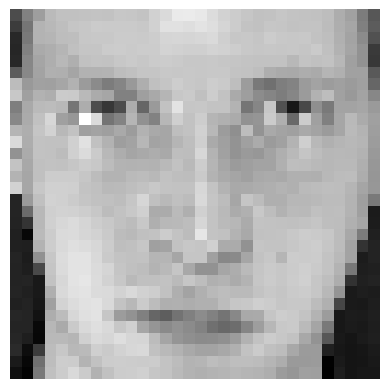

In [24]:
# Display a single example.
show_single_face(data[2, :])

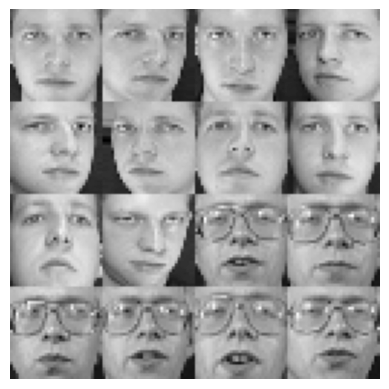

In [25]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [26]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [27]:
def l2_rls_train(data, labels, lmbd):
    """
    Trains our model with some input data and labels, and a lambda value

    data: a numpy array that is the training data of shape num_samples, by num_features.
    labels: a numpy array that is the mapped labels of our data, it is of shape num_samples
    lmbd: a float number that represents our regularisation hyper parameter

    Returns: w - a numpy array holding our trained weights, it is of shape num_features + 1 by num_outputs

    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    # np.ones creates a np array of specified shape, which in our case is num_samples by 1 (we want a column)
    X_tilde = np.concatenate( [ X, np.ones((X.shape[0], 1)) ], axis=1 )
    
    # Compute the coefficient vector.
    # if lmbd != 0,
    #   w = (X_tilde(transposed) * X_tilde + lmbd * identity_matrix)^-1 * X_tilde(transposed) * y
    # else,
    #   use the pseudo inverse to calculate the weights
    if (lmbd != 0):
        identity_matrix = np.identity(X_tilde.shape[1]) # We want an identity matrix of shape (num_features + 1)
        # here @ represents matrix multiplication! (handy little operator)
        w = np.linalg.inv(X_tilde.T @ X_tilde + lmbd*identity_matrix) @ X_tilde.T @ y
        
    else:
        # Get the pseudo inverse of X_tilde
        w = np.linalg.pinv(X_tilde).dot(y)
    
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [28]:
def l2_rls_predict(w, data):
    """
    Predicts some data given some weights, and returns a predicted output

    data: a numpy array that is the test data of shape num_samples, by num_features.
    w: a numpy array holding our trained weights, it is of shape num_features + 1 by num_outputs

    Returns: our predicted y values, as a numpy array of shape num_samples, num_outputs
    """
    
    # recreate our feature vector matrix
    X_tilde = np.concatenate( [ data, np.ones((data.shape[0], 1)) ], axis=1 )
    # Compute the prediction.
    predicted_y = X_tilde @ w
    return predicted_y

### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [29]:
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels
def one_hot_encode(input_labels):
    input_labels_ohe = np.zeros((input_labels.shape[0], 40))
    for i in range(input_labels.shape[0]):
        input_labels_ohe.itemset((i, input_labels[i]-1), 1)
    return input_labels_ohe

# partition the data, with 5 images for both training and testing for each subject
np.set_printoptions(threshold=np.inf) # a config setting to print big arrays for testing - not relevant to experiment
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data, tr_label = data[tr_ind, :], labels[tr_ind]
te_data, te_label = data[te_ind, :], labels[te_ind]

# The lambda values we want to test
lambda_values = [0, 0.0005, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 10, 100]
# How many data splits should we do, i.e. iterations on lambda values
iterations = 5


for lmbd in lambda_values:
    # initialize the accuracy array
    lmbd_accuracy = []

    for i in range(iterations):
        # using random subsampling
        hypo_ind, vali_ind = partition_data(tr_label, num_per_class=4) # Split our data into a hypothesis and validation set
        hypo_data, hypo_label = tr_data[hypo_ind, :], tr_label[hypo_ind]
        vali_data, vali_label = tr_data[vali_ind, :], tr_label[vali_ind]

        # Encode our training data
        hypo_label = one_hot_encode(hypo_label)

        weights = l2_rls_train(hypo_data, hypo_label, lmbd) # train our weights
        predicted_y = l2_rls_predict(weights, vali_data) # get our predicted y!
        predicted_accuracy = np.sum(np.argmax(predicted_y, axis=1) + 1 == vali_label) / predicted_y.shape[0] # calculate the accuracy
        lmbd_accuracy.append(predicted_accuracy)
    print("The mean accuracy for lambda value " + str(lmbd) + " is: " + str("{:.3f}%".format( np.mean(lmbd_accuracy)*100 )) )


The mean accuracy for lambda value 0 is: 91.500%
The mean accuracy for lambda value 0.0005 is: 91.000%
The mean accuracy for lambda value 0.001 is: 93.500%
The mean accuracy for lambda value 0.01 is: 92.000%
The mean accuracy for lambda value 0.1 is: 95.500%
The mean accuracy for lambda value 0.5 is: 93.500%
The mean accuracy for lambda value 1 is: 94.500%
The mean accuracy for lambda value 1.5 is: 96.000%
The mean accuracy for lambda value 2 is: 95.500%
The mean accuracy for lambda value 2.5 is: 94.500%
The mean accuracy for lambda value 3 is: 96.000%
The mean accuracy for lambda value 10 is: 94.000%
The mean accuracy for lambda value 100 is: 88.000%


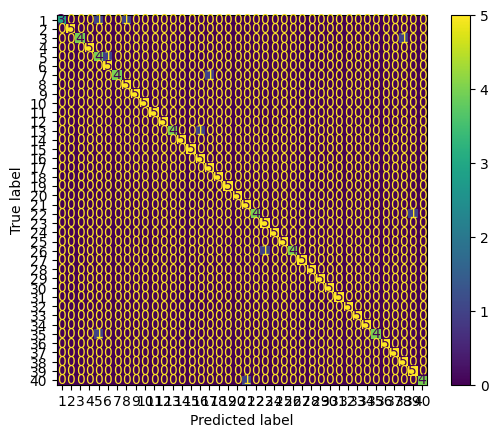

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encode our training data
tr_label_ohe = one_hot_encode(tr_label)

weights = l2_rls_train(tr_data, tr_label_ohe, 2) # I use 2 as my lambda value
predicted_y = l2_rls_predict(weights, te_data) # calculate our predicted y

matrix = confusion_matrix(te_label, np.argmax(predicted_y, axis=1) + 1) # create the confusion matrix
cf_labels = [] # these next 3 lines are used to make the labels appear 1 number higher than they are!
for i in range(40):
    cf_labels.append(i+1)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=cf_labels)
disp.plot()
plt.show()

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Subject 2
Subject 4
Subject 6
Subject 8
Subject 9


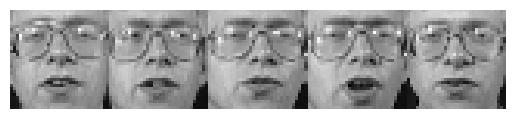

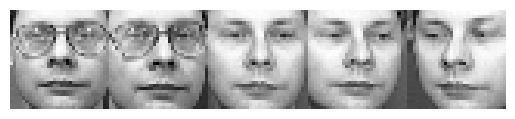

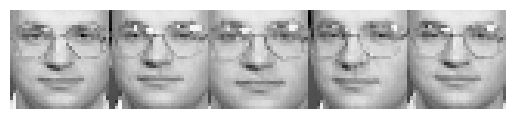

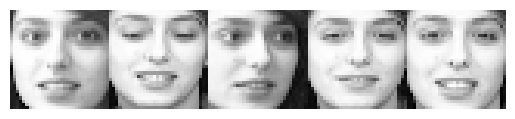

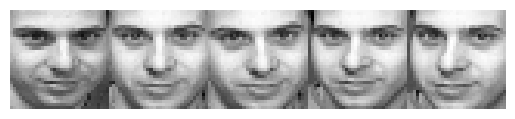

In [31]:
count = 0
for index,subject in enumerate(matrix):
    if (matrix[index][index] == 5):
        print("Subject " + str(index+1))
        count+=1
        show_faces(te_data[(index*5):(index*5)+5, :], num_per_row=5)
    if count == 5:
        break

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

Subject 1 got wrongly classified as 5
Subject 1 got wrongly classified as 8
Subject 3 got wrongly classified as 38
Subject 5 got wrongly classified as 6
Subject 7 got wrongly classified as 17
Subject 13 got wrongly classified as 16
Subject 22 got wrongly classified as 39
Subject 26 got wrongly classified as 23
Subject 35 got wrongly classified as 5
Subject 40 got wrongly classified as 21


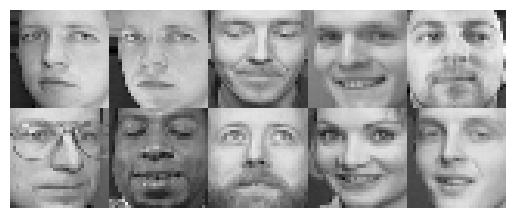

In [32]:
wf_arr = []
for index,test_image in enumerate(te_ind): # Iterate through our test indices
    if (te_label[index] != (np.argmax(predicted_y, axis=1) + 1)[index]): # If the actual != predicted
        print("Subject " + str(te_label[index]) + " got wrongly classified as " + str((np.argmax(predicted_y, axis=1) + 1)[index]))
        wf_arr.append(test_image) # Add the misclassified image
show_faces(data[ wf_arr, :], num_per_row=5)

### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [33]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

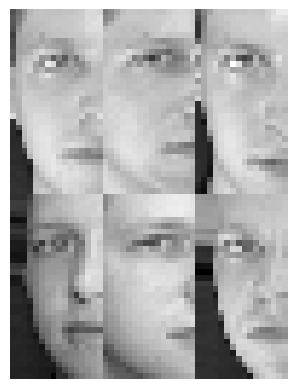

In [34]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

MAPE: 26.21%


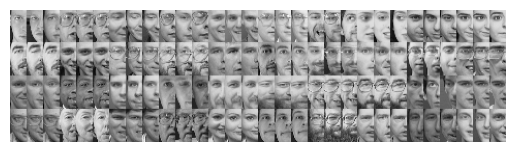

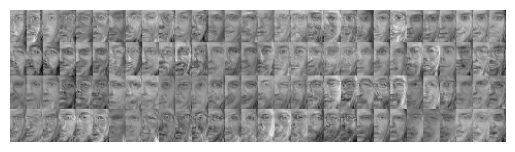

In [35]:
# Your code goes here
tr_ind, te_ind = partition_data(labels, num_per_class=7) # Split our data into testing and training
tr_left, tr_right = split_left_right( data[tr_ind, :] ) # Split it into left and right
te_left, te_right = split_left_right( data[te_ind, :] )
te_data = data[te_ind, :]


weights = l2_rls_train(tr_left, tr_right, 0) # Calculate our weights
predicted_right = l2_rls_predict(weights, te_left) # Calculate our predicted right face

show_split_faces(te_left, num_per_row=30) # Show the faces
show_split_faces(predicted_right, num_per_row=30)

# Mean absolute percentage error
# MAPE = (1/nm)*E(E((real-predicted)/real))
absolute_percentage_error = np.abs(np.divide(np.subtract(te_right, predicted_right), te_right))
mape = np.mean(absolute_percentage_error, axis=0) * 100
mape = np.mean(mape, axis=0)
print(f"MAPE: {mape:.2f}%")


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

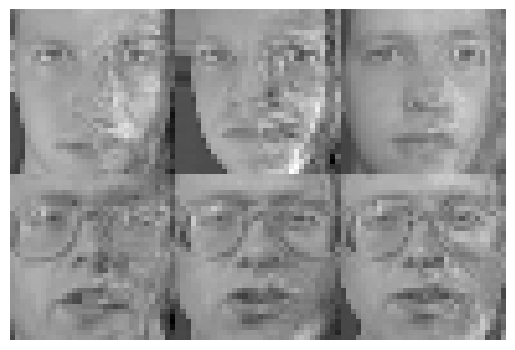

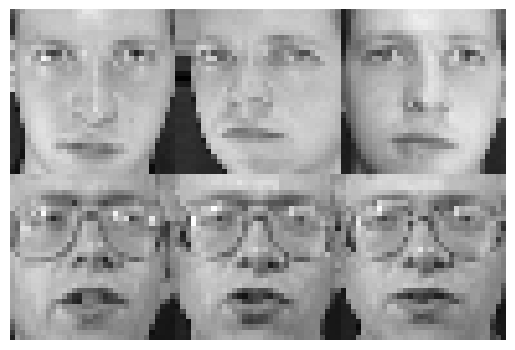

In [36]:
predicted_complete = join_left_right(te_left, predicted_right)

show_faces(predicted_complete[:6], num_per_row=3)
show_faces(te_data[:6], num_per_row=3)

### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [37]:
def lls_gd_train(data, labels, N, learning_rate):
    """
    Trains a model using gradient descent

    data: a numpy array that is the training data of shape num_samples, by num_features.
    labels: a numpy array that is the mapped labels of our data, it is of shape num_samples
    N: the number of iterations
    learning_rate: the learning rate for gradient descent

    Returns:    w_all - a numpy array holding our trained weights, it is of shape num_features + 1 by N
                cost_all - a numpy array holding the cost of each iteration, it is of shape N
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.concatenate( [ np.ones((X.shape[0], 1)) , X ], axis=1 )
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((X_tilde.shape[1], N))
    cost_all = np.zeros(N)
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        # gradient =    ( !X.T * !X * w ) − ( !X.T * Y )

        
        gd = ((X_tilde.T.dot(X_tilde)).dot(w)) - (X_tilde.T).dot(y) 

        cost_all[i] = 0.5 * np.sum(np.power((X_tilde.dot(w) - y),2),axis=0)
        
        # Weight update
        # w^t+1 = w^t - learning_rate * gd 
        w = w - (learning_rate * gd)
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all[ : , i ] = w
    
    
    # Return model parameters.
    return cost_all, w_all

### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

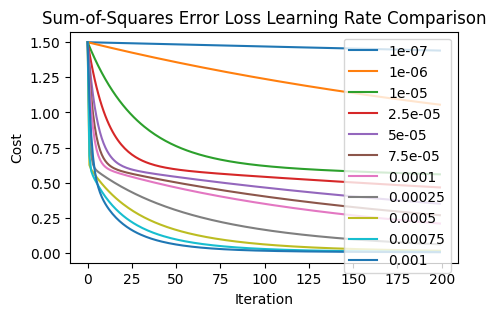

In [47]:
# partition the data, with 3 images for training and 7 for testing for each subject
# get subject 1 and 30
new_ind = (np.where((labels==1) | (labels==30)))
new_data, new_labels = data[new_ind], labels[new_ind]
# Encode our labels to 1 (subject 1) or 0 (subject 30)
new_labels = np.where((new_labels==1),1,0)

# split it into our training and test data
tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
tr_data, tr_label = new_data[tr_ind, :], new_labels[tr_ind]
te_data, te_label = new_data[te_ind, :], new_labels[te_ind]

# The learning rates value + the iteration number
learning_rates = [0.0000001, 0.000001, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001]
iterations = 200

### (1) Plot the Sum-Of-Squares Error Loss over iteration, for each learning rate
plt.figure(figsize=(5, 3))
for learning_rate in learning_rates:
    cost, weights = lls_gd_train(tr_data, tr_label, iterations, learning_rate) # train our weights
    plt.plot(range(iterations), cost, label=str(learning_rate))
    plt.title("Sum-of-Squares Error Loss Learning Rate Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")

plt.legend()
plt.show()

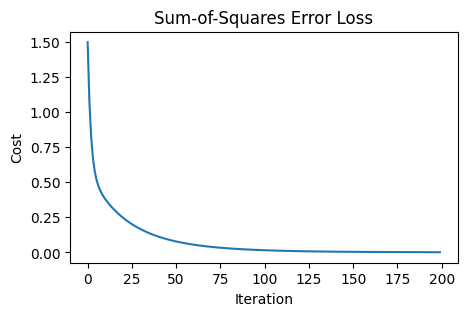

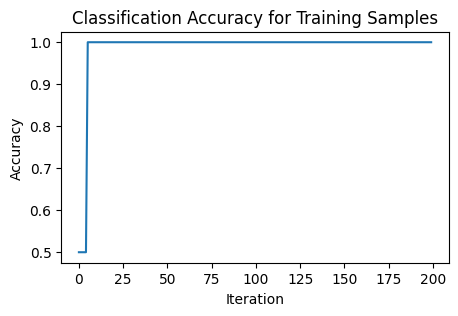

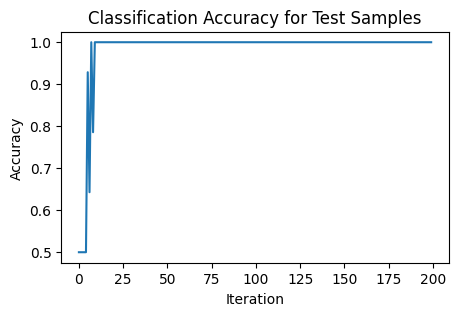

In [39]:
# partition the data, with 3 images for training and 7 for testing for each subject
# get subject 1 and 30
new_ind = (np.where((labels==1) | (labels==30)))
new_data, new_labels = data[new_ind], labels[new_ind]
# Encode our labels to 1 (subject 1) or 0 (subject 30)
new_labels = np.where((new_labels==1),1,0)

# split it into our training and test data
tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
tr_data, tr_label = new_data[tr_ind, :], new_labels[tr_ind]
te_data, te_label = new_data[te_ind, :], new_labels[te_ind]

# The learning rate value + the iteration number
learning_rate = 0.001
iterations = 200

cost, weights = lls_gd_train(tr_data, tr_label, iterations, learning_rate) # train our weights

### (1) Plot the Sum-Of-Squares Error Loss over iteration
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), cost)
plt.title("Sum-of-Squares Error Loss")
plt.xlabel("Iteration")
plt.ylabel("Cost")

### (2) Plot the accuracy for training samples over iterations
tr_label_new = np.repeat([tr_label], [iterations], axis=0).T
# Get the cost and accuracy for GD
tr_cost = np.sum(np.square(l2_rls_predict(weights, tr_data) - tr_label_new)) / (2 * len(tr_label))
tr_acc = np.mean(np.round(l2_rls_predict(weights, tr_data)) == tr_label_new)
tr_accuracies = []
for i in range(iterations): # Get the accuracy for each iteration
    tr_predicted = l2_rls_predict(weights[:, i], tr_data)
    tr_accuracies.append(np.mean(np.round(tr_predicted) == tr_label))
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), tr_accuracies)
plt.title("Classification Accuracy for Training Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

### (3) Plot the accuracy for test samples over iterations
predicted_y = l2_rls_predict(weights, te_data) # get our predicted y!
te_label_new = np.repeat([te_label], [iterations], axis=0).T
# Get the cost and accuracy for GD
te_cost = np.sum(np.square(predicted_y - te_label_new)) / (2 * len(te_label_new)) 
te_accuracys = [] # Initialize accuracies array

for i in range(iterations): # Find the classification accuracy for each iteration
    te_predicted = predicted_y[:, i] # get the predicted value for this iteration
    te_accuracys.append(np.mean(np.round(te_predicted) == te_label)) # Rount it and check if it's correct against the label. mean this value

plt.figure(figsize=(5, 3))
plt.plot(range(iterations), te_accuracys)
plt.title("Classification Accuracy for Test Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")



plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

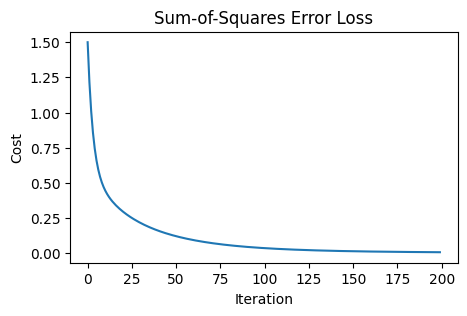

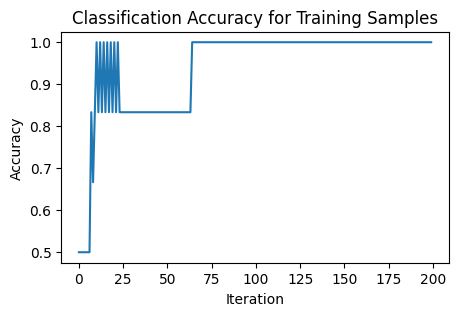

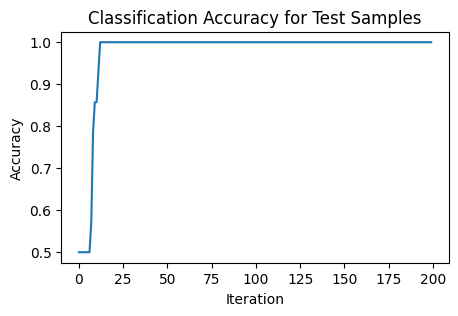

In [40]:
# partition the data, with 3 images for training and 7 for testing for each subject
# get subject 1 and 30
new_ind = (np.where((labels==1) | (labels==30)))
new_data, new_labels = data[new_ind], labels[new_ind]
# Encode our labels to 1 (subject 1) or 0 (subject 30)
new_labels = np.where((new_labels==1),1,0)

# split it into our training and test data
tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
tr_data, tr_label = new_data[tr_ind, :], new_labels[tr_ind]
te_data, te_label = new_data[te_ind, :], new_labels[te_ind]

# The learning rate value + the iteration number
learning_rate = 0.001
iterations = 200

cost, weights = lls_gd_train(tr_data, tr_label, iterations, learning_rate) # train our weights

### (1) Plot the Sum-Of-Squares Error Loss over iteration
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), cost)
plt.title("Sum-of-Squares Error Loss")
plt.xlabel("Iteration")
plt.ylabel("Cost")

### (2) Plot the accuracy for training samples over iterations
tr_label_new = np.repeat([tr_label], [iterations], axis=0).T
# Get the cost and accuracy for GD
tr_cost = np.sum(np.square(l2_rls_predict(weights, tr_data) - tr_label_new)) / (2 * len(tr_label))
tr_acc = np.mean(np.round(l2_rls_predict(weights, tr_data)) == tr_label_new)
tr_accuracies = []
for i in range(iterations): # Get the accuracy for each iteration
    tr_predicted = l2_rls_predict(weights[:, i], tr_data)
    tr_accuracies.append(np.mean(np.round(tr_predicted) == tr_label))
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), tr_accuracies)
plt.title("Classification Accuracy for Training Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

### (3) Plot the accuracy for test samples over iterations
predicted_y = l2_rls_predict(weights, te_data) # get our predicted y!
te_label_new = np.repeat([te_label], [iterations], axis=0).T

# Get the cost and accuracy for GD
te_cost = np.sum(np.square(predicted_y - te_label_new)) / (2 * len(te_label_new)) 
te_accuracys = [] # Initialize accuracies array

for i in range(iterations): # Find the classification accuracy for each iteration
    te_predicted = predicted_y[:, i] # get the predicted value for this iteration
    te_accuracys.append(np.mean(np.round(te_predicted) == te_label)) # Rount it and check if it's correct against the label. mean this value

plt.figure(figsize=(5, 3))
plt.plot(range(iterations), te_accuracys)
plt.title("Classification Accuracy for Test Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")



plt.show()

### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [41]:
def lls_sgd_train(data, labels, N, learning_rate):
    """
    A summary of your function goes here.

    data: a numpy array that is the training data of shape num_samples, by num_features.
    labels: a numpy array that is the mapped labels of our data, it is of shape num_samples
    N: the number of iterations
    learning_rate: the learning rate for gradient descent

    Returns:    w_all - a numpy array holding our trained weights, it is of shape num_features + 1 by N
                cost_all - a numpy array holding the cost of each iteration, it is of shape N
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.concatenate( [ np.ones((X.shape[0], 1)) , X ], axis=1 )
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((X_tilde.shape[1], N))
    cost_all = np.zeros(N)
    
    # SGD update of weights
    for i in range(N):
        # Select a random data point
        j = np.random.randint(X_tilde.shape[0])

        # Predict the output using the current weights, and random 
        predicted_y = X_tilde[j].dot(w)
        # Get the correct output
        correct_y = y[j]

        # Compute the error, which we use for our stochastic gradient descent
        error = predicted_y - correct_y
        sgd = error * X_tilde[j]

        # Update the weights using our learning rate
        w = w - ( learning_rate * sgd )        
        # compute the cost using the entire dataset
        cost_all[i] = np.power( np.sum((X_tilde.dot(w) - y)) ,2) / 2

        # Save the weights at this iteration
        w_all[:, i] = w


    # Return model parameters.
    return cost_all, w_all

### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


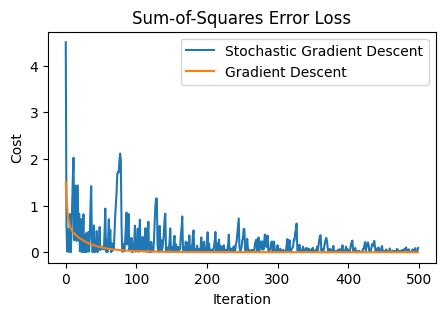

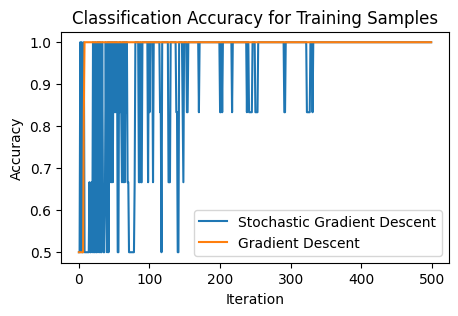

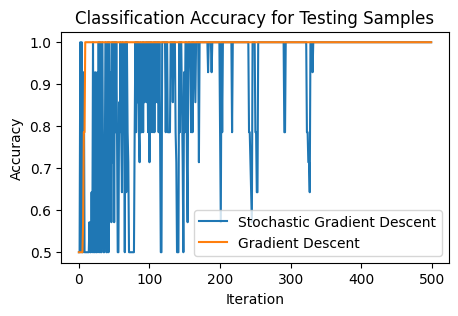

In [53]:
# partition the data, with 3 images for training and 7 for testing for each subject
# get subject 1 and 30
new_ind = (np.where((labels==1) | (labels==30)))
new_data, new_labels = data[new_ind], labels[new_ind]
# Encode our labels to 1 (subject 1) or 0 (subject 30)
new_labels = np.where((new_labels==1),1,0)

# split it into our training and test data
tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
tr_data, tr_label = new_data[tr_ind, :], new_labels[tr_ind]
te_data, te_label = new_data[te_ind, :], new_labels[te_ind]

# The learning rate value + the iteration number
learning_rate = 0.001
iterations = 500

sgd_cost, sgd_weights = lls_sgd_train(tr_data, tr_label, iterations, learning_rate) # train our weights
gd_cost, gd_weights = lls_gd_train(tr_data, tr_label, iterations, learning_rate) # train our weights

### (1) Plot the Sum-Of-Squares Error Loss over iteration, for both gd and sgd
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), sgd_cost, label='Stochastic Gradient Descent')
plt.plot(range(iterations), gd_cost, label='Gradient Descent')
plt.title("Sum-of-Squares Error Loss")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

### (2) Plot the accuracy for training samples over iterations,  for both gd and sgd
tr_label_new = np.repeat([tr_label], [iterations], axis=0).T

# Get the cost, and accuracy for GD
gd_tr_cost = np.sum(np.square(l2_rls_predict(gd_weights, tr_data) - tr_label_new)) / (2 * len(tr_label))
gd_tr_acc = np.mean(np.round(l2_rls_predict(gd_weights, tr_data)) == tr_label_new)
gd_tr_accuracies = []

# Get the cost, and accuracy for SGD
sgd_tr_cost = np.sum(np.square(l2_rls_predict(sgd_weights, tr_data) - tr_label_new)) / (2 * len(tr_label))
sgd_tr_acc = np.mean(np.round(l2_rls_predict(sgd_weights, tr_data)) == tr_label_new)
sgd_tr_accuracies = []

for i in range(iterations): # For each iteration, get the prediction and append the accuracy 
    gd_tr_predicted = l2_rls_predict(gd_weights[:, i], tr_data)
    gd_tr_accuracies.append(np.mean(np.round(gd_tr_predicted) == tr_label))
    sgd_tr_predicted = l2_rls_predict(sgd_weights[:, i], tr_data)
    sgd_tr_accuracies.append(np.mean(np.round(sgd_tr_predicted) == tr_label))
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), sgd_tr_accuracies, label='Stochastic Gradient Descent')
plt.plot(range(iterations), gd_tr_accuracies, label='Gradient Descent')
plt.title("Classification Accuracy for Training Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()


### (3) Plot the accuracy for training samples over iterations,  for both gd and sgd
te_label_new = np.repeat([te_label], [iterations], axis=0).T

# Get the cost, and accuracy for GD
gd_te_cost = np.sum(np.square(l2_rls_predict(gd_weights, te_data) - te_label_new)) / (2 * len(te_label))
gd_te_acc = np.mean(np.round(l2_rls_predict(gd_weights, te_data)) == te_label_new)
gd_te_accuracies = []

# Get the cost, and accuracy for SGD
sgd_te_cost = np.sum(np.square(l2_rls_predict(sgd_weights, te_data) - te_label_new)) / (2 * len(te_label))
sgd_te_acc = np.mean(np.round(l2_rls_predict(sgd_weights, te_data)) == te_label_new)
sgd_te_accuracies = []

for i in range(iterations): # For each iteration, get the prediction and append the accuracy 
    gd_te_predicted = l2_rls_predict(gd_weights[:, i], te_data)
    gd_te_accuracies.append(np.mean(np.round(gd_te_predicted) == te_label))
    sgd_te_predicted = l2_rls_predict(sgd_weights[:, i], te_data)
    sgd_te_accuracies.append(np.mean(np.round(sgd_te_predicted) == te_label))
plt.figure(figsize=(5, 3))
plt.plot(range(iterations), sgd_te_accuracies, label='Stochastic Gradient Descent')
plt.plot(range(iterations), gd_te_accuracies, label='Gradient Descent')
plt.title("Classification Accuracy for Testing Samples")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()



plt.show()

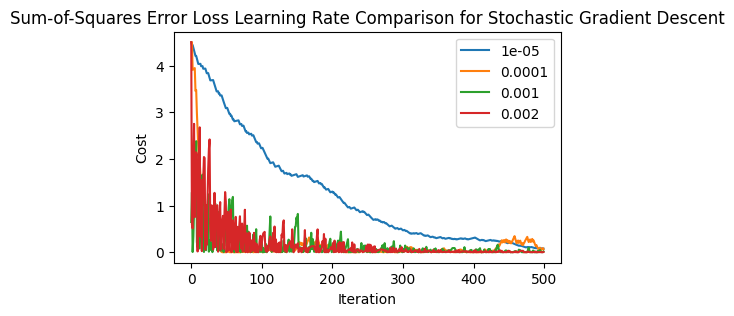

In [55]:
# partition the data, with 3 images for training and 7 for testing for each subject
# get subject 1 and 30
new_ind = (np.where((labels==1) | (labels==30)))
new_data, new_labels = data[new_ind], labels[new_ind]
# Encode our labels to 1 (subject 1) or 0 (subject 30)
new_labels = np.where((new_labels==1),1,0)

# split it into our training and test data
tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
tr_data, tr_label = new_data[tr_ind, :], new_labels[tr_ind]
te_data, te_label = new_data[te_ind, :], new_labels[te_ind]

# The learning rates value + the iteration number
learning_rates = [0.00001, 0.0001, 0.001, 0.002]
iterations = 500

### (1) Plot the Sum-Of-Squares Error Loss over iteration, for each learning rate
plt.figure(figsize=(5, 3))
for learning_rate in learning_rates:
    sgd_cost, sgd_weights = lls_sgd_train(tr_data, tr_label, iterations, learning_rate) # train our weights
    plt.plot(range(iterations), sgd_cost, label=str(learning_rate))
    plt.title("Sum-of-Squares Error Loss Learning Rate Comparison for Stochastic Gradient Descent")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")

plt.legend()
plt.show()

### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [20]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [21]:
# Your code goes here

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**